In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [22]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [23]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [25]:
# For model construction
from collections import OrderedDict

In [26]:
# Import tqdm for progress bar construction
import tqdm

In [27]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [28]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [29]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [30]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'train_metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [31]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

In [32]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

In [33]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 16
birdclef_epoch = 20

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# Densnet121 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.densnet121 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)
#        self.googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.densnet121(x)
#        x = self.googlenet(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, loss, epoch, index):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './bird_specificator_Densenet121.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    
    
    for e in range(epoch):
        if e < saved_epoch:
            continue
        
        if len(val_losses) == 0 and saved_epoch > -1:
            acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
            val_losses.append(acc)
            train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
            log_scores.append(log_score)
            fbeta_scores.append(fbeta_score)
            
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # every epoch, save the model
        checkpoint(model, optimizer, epoch_losses, e, index)
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Model2(
  (densnet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


In [34]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
#    optimizer = optim.Adam(model.parameters(), lr=learning_rate_1, weight_decay=weight_decay_1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [35]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [36]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                               | 1/2357 [00:02<1:41:27,  2.58s/it]

Iteration 0, loss = 6.4890


  4%|███▎                                                                         | 101/2357 [04:22<1:37:32,  2.59s/it]

Iteration 100, loss = 6.3967


  9%|██████▌                                                                      | 201/2357 [08:43<1:31:20,  2.54s/it]

Iteration 200, loss = 6.2262


 13%|█████████▊                                                                   | 301/2357 [13:00<1:29:30,  2.61s/it]

Iteration 300, loss = 6.3057


 17%|█████████████                                                                | 401/2357 [17:22<1:25:09,  2.61s/it]

Iteration 400, loss = 6.2227


 21%|████████████████▎                                                            | 501/2357 [21:46<1:26:30,  2.80s/it]

Iteration 500, loss = 6.0210


 25%|███████████████████▋                                                         | 601/2357 [26:07<1:16:47,  2.62s/it]

Iteration 600, loss = 6.0826


 30%|██████████████████████▉                                                      | 701/2357 [30:27<1:14:11,  2.69s/it]

Iteration 700, loss = 6.0091


 34%|██████████████████████████▏                                                  | 801/2357 [34:47<1:11:00,  2.74s/it]

Iteration 800, loss = 5.8825


 38%|█████████████████████████████▍                                               | 901/2357 [39:08<1:02:20,  2.57s/it]

Iteration 900, loss = 6.0381


 42%|█████████████████████████████████▏                                            | 1001/2357 [43:27<58:47,  2.60s/it]

Iteration 1000, loss = 6.0272


 47%|████████████████████████████████████▍                                         | 1101/2357 [47:48<54:35,  2.61s/it]

Iteration 1100, loss = 5.8933


 51%|███████████████████████████████████████▋                                      | 1201/2357 [52:10<49:45,  2.58s/it]

Iteration 1200, loss = 5.7661


 55%|███████████████████████████████████████████                                   | 1301/2357 [56:32<47:37,  2.71s/it]

Iteration 1300, loss = 6.0491


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:00:52<40:45,  2.56s/it]

Iteration 1400, loss = 6.1146


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:05:12<37:46,  2.65s/it]

Iteration 1500, loss = 6.2292


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:09:35<32:35,  2.59s/it]

Iteration 1600, loss = 6.4145


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:13:53<28:12,  2.58s/it]

Iteration 1700, loss = 5.9218


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:18:13<24:14,  2.62s/it]

Iteration 1800, loss = 5.8878


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:22:34<19:30,  2.57s/it]

Iteration 1900, loss = 6.0517


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:26:54<15:16,  2.57s/it]

Iteration 2000, loss = 6.1146


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:31:16<10:43,  2.52s/it]

Iteration 2100, loss = 6.2356


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:35:43<06:55,  2.66s/it]

Iteration 2200, loss = 5.7185


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:40:11<02:25,  2.60s/it]

Iteration 2300, loss = 6.1733


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:42:40<00:00,  2.61s/it]


Checking accuracy score on validation set.

Accuracy: 144 / 12575 correct (1.15)
Log Loss score:	5.96
Fbeta-score (beta=1): 	0.01
Training model 2, epoch 2


  0%|                                                                               | 1/2357 [00:02<1:43:48,  2.64s/it]

Iteration 0, loss = 6.2492


  4%|███▎                                                                         | 101/2357 [04:30<1:42:03,  2.71s/it]

Iteration 100, loss = 6.0071


  9%|██████▌                                                                      | 201/2357 [09:24<1:51:15,  3.10s/it]

Iteration 200, loss = 5.8761


 13%|█████████▊                                                                   | 301/2357 [14:36<1:44:20,  3.05s/it]

Iteration 300, loss = 5.8450


 17%|█████████████                                                                | 401/2357 [19:41<1:38:12,  3.01s/it]

Iteration 400, loss = 5.7384


 21%|████████████████▎                                                            | 501/2357 [24:36<1:31:37,  2.96s/it]

Iteration 500, loss = 5.9069


 25%|███████████████████▋                                                         | 601/2357 [29:33<1:27:34,  2.99s/it]

Iteration 600, loss = 5.7093


 30%|██████████████████████▉                                                      | 701/2357 [34:34<1:25:36,  3.10s/it]

Iteration 700, loss = 5.8633


 34%|██████████████████████████▏                                                  | 801/2357 [39:21<1:17:14,  2.98s/it]

Iteration 800, loss = 5.7471


 38%|█████████████████████████████▍                                               | 901/2357 [44:19<1:14:27,  3.07s/it]

Iteration 900, loss = 6.0217


 42%|████████████████████████████████▎                                           | 1001/2357 [49:15<1:02:13,  2.75s/it]

Iteration 1000, loss = 5.7306


 47%|████████████████████████████████████▍                                         | 1101/2357 [54:13<56:11,  2.68s/it]

Iteration 1100, loss = 6.1876


 51%|███████████████████████████████████████▋                                      | 1201/2357 [59:04<55:57,  2.90s/it]

Iteration 1200, loss = 5.8736


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:04:28<57:29,  3.27s/it]

Iteration 1300, loss = 5.7858


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:10:06<54:42,  3.43s/it]

Iteration 1400, loss = 5.8942


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:14:20<34:18,  2.41s/it]

Iteration 1500, loss = 5.6850


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:18:23<29:54,  2.37s/it]

Iteration 1600, loss = 5.8908


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:22:26<26:55,  2.46s/it]

Iteration 1700, loss = 5.7650


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:26:29<22:43,  2.45s/it]

Iteration 1800, loss = 5.6615


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:30:31<18:22,  2.42s/it]

Iteration 1900, loss = 5.6425


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:34:34<14:25,  2.43s/it]

Iteration 2000, loss = 5.6400


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:38:37<10:22,  2.43s/it]

Iteration 2100, loss = 6.1090


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:42:38<06:17,  2.42s/it]

Iteration 2200, loss = 5.7392


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:46:34<02:12,  2.36s/it]

Iteration 2300, loss = 5.6138


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:48:45<00:00,  2.77s/it]


Checking accuracy score on validation set.

Accuracy: 173 / 12575 correct (1.38)
Log Loss score:	5.78
Fbeta-score (beta=1): 	0.01
Training model 2, epoch 3


  0%|                                                                               | 1/2357 [00:02<1:29:33,  2.28s/it]

Iteration 0, loss = 5.7251


  4%|███▎                                                                         | 101/2357 [03:55<1:26:27,  2.30s/it]

Iteration 100, loss = 5.9997


  9%|██████▌                                                                      | 201/2357 [07:49<1:23:12,  2.32s/it]

Iteration 200, loss = 5.9970


 13%|█████████▊                                                                   | 301/2357 [11:44<1:20:47,  2.36s/it]

Iteration 300, loss = 6.1755


 17%|█████████████                                                                | 401/2357 [15:39<1:16:46,  2.36s/it]

Iteration 400, loss = 5.7312


 21%|████████████████▎                                                            | 501/2357 [19:33<1:12:08,  2.33s/it]

Iteration 500, loss = 5.9295


 25%|███████████████████▋                                                         | 601/2357 [23:28<1:08:02,  2.32s/it]

Iteration 600, loss = 5.4507


 30%|██████████████████████▉                                                      | 701/2357 [27:23<1:04:40,  2.34s/it]

Iteration 700, loss = 5.6966


 34%|██████████████████████████▏                                                  | 801/2357 [31:18<1:01:46,  2.38s/it]

Iteration 800, loss = 5.9668


 38%|██████████████████████████████▏                                                | 901/2357 [35:13<56:28,  2.33s/it]

Iteration 900, loss = 5.9640


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:07<51:39,  2.29s/it]

Iteration 1000, loss = 5.8457


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:02<47:58,  2.29s/it]

Iteration 1100, loss = 5.9902


 51%|███████████████████████████████████████▋                                      | 1201/2357 [46:56<45:20,  2.35s/it]

Iteration 1200, loss = 5.8285


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:50<41:36,  2.36s/it]

Iteration 1300, loss = 5.4959


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:46<37:18,  2.34s/it]

Iteration 1400, loss = 5.6731


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:40<33:11,  2.33s/it]

Iteration 1500, loss = 5.8133


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:35<29:36,  2.35s/it]

Iteration 1600, loss = 6.1379


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:30<25:41,  2.35s/it]

Iteration 1700, loss = 5.3901


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:25<21:48,  2.35s/it]

Iteration 1800, loss = 5.5303


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:21<17:58,  2.37s/it]

Iteration 1900, loss = 5.5330


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:15<13:34,  2.29s/it]

Iteration 2000, loss = 5.7251


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:09<09:50,  2.31s/it]

Iteration 2100, loss = 5.6013


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:05<06:11,  2.38s/it]

Iteration 2200, loss = 5.8382


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:01<02:13,  2.38s/it]

Iteration 2300, loss = 5.4295


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:13<00:00,  2.35s/it]


Checking accuracy score on validation set.

Accuracy: 280 / 12575 correct (2.23)
Log Loss score:	5.69
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 4


  0%|                                                                               | 1/2357 [00:02<1:34:27,  2.41s/it]

Iteration 0, loss = 5.8142


  4%|███▎                                                                         | 101/2357 [03:57<1:28:15,  2.35s/it]

Iteration 100, loss = 5.7483


  9%|██████▌                                                                      | 201/2357 [07:51<1:23:46,  2.33s/it]

Iteration 200, loss = 5.5196


 13%|█████████▊                                                                   | 301/2357 [11:47<1:19:28,  2.32s/it]

Iteration 300, loss = 5.8398


 17%|█████████████                                                                | 401/2357 [15:42<1:16:38,  2.35s/it]

Iteration 400, loss = 6.1111


 21%|████████████████▎                                                            | 501/2357 [19:37<1:12:21,  2.34s/it]

Iteration 500, loss = 6.0314


 25%|███████████████████▋                                                         | 601/2357 [23:32<1:07:50,  2.32s/it]

Iteration 600, loss = 5.6858


 30%|██████████████████████▉                                                      | 701/2357 [27:26<1:05:09,  2.36s/it]

Iteration 700, loss = 5.6265


 34%|██████████████████████████▏                                                  | 801/2357 [31:22<1:01:15,  2.36s/it]

Iteration 800, loss = 5.4828


 38%|██████████████████████████████▏                                                | 901/2357 [35:18<57:05,  2.35s/it]

Iteration 900, loss = 5.6185


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:13<53:47,  2.38s/it]

Iteration 1000, loss = 5.0233


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:08<49:32,  2.37s/it]

Iteration 1100, loss = 5.4757


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:04<45:50,  2.38s/it]

Iteration 1200, loss = 5.9348


 55%|███████████████████████████████████████████                                   | 1301/2357 [50:59<41:56,  2.38s/it]

Iteration 1300, loss = 5.5097


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:55<37:30,  2.35s/it]

Iteration 1400, loss = 5.5272


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:51<33:13,  2.33s/it]

Iteration 1500, loss = 5.5949


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:48<29:53,  2.37s/it]

Iteration 1600, loss = 5.7192


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:43<25:44,  2.36s/it]

Iteration 1700, loss = 5.5152


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:38<21:48,  2.35s/it]

Iteration 1800, loss = 5.2797


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:34<17:43,  2.33s/it]

Iteration 1900, loss = 5.6619


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:30<13:59,  2.36s/it]

Iteration 2000, loss = 5.5422


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:26<10:03,  2.36s/it]

Iteration 2100, loss = 5.0495


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:23<06:05,  2.34s/it]

Iteration 2200, loss = 5.4720


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:19<02:11,  2.35s/it]

Iteration 2300, loss = 5.4670


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:32<00:00,  2.36s/it]


Checking accuracy score on validation set.

Accuracy: 553 / 12575 correct (4.40)
Log Loss score:	5.50
Fbeta-score (beta=1): 	0.04
Training model 2, epoch 5


  0%|                                                                               | 1/2357 [00:02<1:35:02,  2.42s/it]

Iteration 0, loss = 6.0387


  4%|███▎                                                                         | 101/2357 [03:57<1:27:21,  2.32s/it]

Iteration 100, loss = 5.0857


  9%|██████▌                                                                      | 201/2357 [07:53<1:24:39,  2.36s/it]

Iteration 200, loss = 5.5201


 13%|█████████▊                                                                   | 301/2357 [11:49<1:22:08,  2.40s/it]

Iteration 300, loss = 6.0823


 17%|█████████████                                                                | 401/2357 [15:45<1:17:33,  2.38s/it]

Iteration 400, loss = 5.6700


 21%|████████████████▎                                                            | 501/2357 [19:40<1:14:54,  2.42s/it]

Iteration 500, loss = 5.5262


 25%|███████████████████▋                                                         | 601/2357 [23:35<1:08:22,  2.34s/it]

Iteration 600, loss = 4.9721


 30%|██████████████████████▉                                                      | 701/2357 [27:31<1:05:52,  2.39s/it]

Iteration 700, loss = 5.6504


 34%|██████████████████████████▏                                                  | 801/2357 [31:27<1:01:28,  2.37s/it]

Iteration 800, loss = 5.5562


 38%|██████████████████████████████▏                                                | 901/2357 [35:22<57:18,  2.36s/it]

Iteration 900, loss = 5.5899


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:17<53:11,  2.35s/it]

Iteration 1000, loss = 5.3587


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:15<49:51,  2.38s/it]

Iteration 1100, loss = 5.4405


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:14<46:03,  2.39s/it]

Iteration 1200, loss = 5.4751


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:11<40:35,  2.31s/it]

Iteration 1300, loss = 5.6784


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [55:07<37:55,  2.38s/it]

Iteration 1400, loss = 5.2037


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [59:02<33:37,  2.36s/it]

Iteration 1500, loss = 5.4771


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:59<29:46,  2.36s/it]

Iteration 1600, loss = 5.8013


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:55<25:32,  2.34s/it]

Iteration 1700, loss = 5.4819


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:51<21:50,  2.36s/it]

Iteration 1800, loss = 5.2748


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:47<17:55,  2.36s/it]

Iteration 1900, loss = 5.2542


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:42<13:58,  2.35s/it]

Iteration 2000, loss = 5.3539


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:36<09:53,  2.32s/it]

Iteration 2100, loss = 5.6150


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:30<06:04,  2.34s/it]

Iteration 2200, loss = 5.0685


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:26<02:13,  2.39s/it]

Iteration 2300, loss = 5.7194


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:37<00:00,  2.36s/it]


Checking accuracy score on validation set.

Accuracy: 994 / 12575 correct (7.90)
Log Loss score:	5.22
Fbeta-score (beta=1): 	0.08
Training model 2, epoch 6


  0%|                                                                               | 1/2357 [00:02<1:39:17,  2.53s/it]

Iteration 0, loss = 4.4872


  4%|███▎                                                                         | 101/2357 [03:57<1:28:19,  2.35s/it]

Iteration 100, loss = 5.3422


  9%|██████▌                                                                      | 201/2357 [07:53<1:22:47,  2.30s/it]

Iteration 200, loss = 5.2423


 13%|█████████▊                                                                   | 301/2357 [11:49<1:21:20,  2.37s/it]

Iteration 300, loss = 5.2138


 17%|█████████████                                                                | 401/2357 [15:44<1:14:37,  2.29s/it]

Iteration 400, loss = 4.4586


 21%|████████████████▎                                                            | 501/2357 [19:40<1:12:01,  2.33s/it]

Iteration 500, loss = 4.9360


 25%|███████████████████▋                                                         | 601/2357 [23:35<1:09:23,  2.37s/it]

Iteration 600, loss = 5.0785


 30%|██████████████████████▉                                                      | 701/2357 [27:30<1:04:32,  2.34s/it]

Iteration 700, loss = 4.7968


 34%|██████████████████████████▏                                                  | 801/2357 [31:24<1:00:18,  2.33s/it]

Iteration 800, loss = 4.7763


 38%|██████████████████████████████▏                                                | 901/2357 [35:18<55:32,  2.29s/it]

Iteration 900, loss = 3.9700


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:13<52:11,  2.31s/it]

Iteration 1000, loss = 4.4801


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:08<49:17,  2.36s/it]

Iteration 1100, loss = 5.3626


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:05<45:48,  2.38s/it]

Iteration 1200, loss = 4.5393


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:02<41:16,  2.35s/it]

Iteration 1300, loss = 5.3598


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [54:58<37:15,  2.34s/it]

Iteration 1400, loss = 4.8697


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [58:54<33:11,  2.33s/it]

Iteration 1500, loss = 4.9517


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:02:51<30:32,  2.42s/it]

Iteration 1600, loss = 4.7592


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:06:48<26:15,  2.40s/it]

Iteration 1700, loss = 5.2458


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:10:46<22:19,  2.41s/it]

Iteration 1800, loss = 4.9359


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:43<18:17,  2.41s/it]

Iteration 1900, loss = 5.2586


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:40<13:51,  2.34s/it]

Iteration 2000, loss = 4.9619


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:38<09:52,  2.31s/it]

Iteration 2100, loss = 4.9139


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:36<06:11,  2.38s/it]

Iteration 2200, loss = 4.7725


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:33<02:10,  2.32s/it]

Iteration 2300, loss = 5.3067


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:32:47<00:00,  2.36s/it]


Checking accuracy score on validation set.

Accuracy: 1478 / 12575 correct (11.75)
Log Loss score:	4.82
Fbeta-score (beta=1): 	0.12
Training model 2, epoch 7


  0%|                                                                               | 1/2357 [00:02<1:51:12,  2.83s/it]

Iteration 0, loss = 4.6018


  4%|███▎                                                                         | 101/2357 [04:28<1:41:40,  2.70s/it]

Iteration 100, loss = 4.7821


  9%|██████▌                                                                      | 201/2357 [08:53<1:34:12,  2.62s/it]

Iteration 200, loss = 4.3486


 13%|█████████▊                                                                   | 301/2357 [13:15<1:30:27,  2.64s/it]

Iteration 300, loss = 4.5397


 17%|█████████████                                                                | 401/2357 [17:34<1:26:16,  2.65s/it]

Iteration 400, loss = 4.9008


 21%|████████████████▎                                                            | 501/2357 [21:56<1:21:08,  2.62s/it]

Iteration 500, loss = 4.0741


 25%|███████████████████▋                                                         | 601/2357 [26:18<1:16:24,  2.61s/it]

Iteration 600, loss = 4.4662


 30%|██████████████████████▉                                                      | 701/2357 [30:40<1:14:06,  2.69s/it]

Iteration 700, loss = 4.0225


 34%|██████████████████████████▏                                                  | 801/2357 [34:55<1:06:06,  2.55s/it]

Iteration 800, loss = 5.0829


 38%|█████████████████████████████▍                                               | 901/2357 [39:18<1:03:17,  2.61s/it]

Iteration 900, loss = 4.4805


 42%|█████████████████████████████████▏                                            | 1001/2357 [43:39<59:15,  2.62s/it]

Iteration 1000, loss = 4.5020


 47%|████████████████████████████████████▍                                         | 1101/2357 [48:00<54:13,  2.59s/it]

Iteration 1100, loss = 4.8972


 51%|███████████████████████████████████████▋                                      | 1201/2357 [52:22<49:58,  2.59s/it]

Iteration 1200, loss = 4.2869


 55%|███████████████████████████████████████████                                   | 1301/2357 [56:44<46:16,  2.63s/it]

Iteration 1300, loss = 4.4955


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:01:07<42:02,  2.64s/it]

Iteration 1400, loss = 4.5054


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:05:28<36:29,  2.56s/it]

Iteration 1500, loss = 4.3293


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:09:49<32:55,  2.61s/it]

Iteration 1600, loss = 4.4611


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:14:10<28:52,  2.64s/it]

Iteration 1700, loss = 4.4128


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:18:26<24:39,  2.66s/it]

Iteration 1800, loss = 4.2787


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:22:49<19:43,  2.60s/it]

Iteration 1900, loss = 4.9796


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:27:11<15:23,  2.59s/it]

Iteration 2000, loss = 4.8014


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:31:33<11:08,  2.61s/it]

Iteration 2100, loss = 4.7048


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:35:47<06:38,  2.55s/it]

Iteration 2200, loss = 4.9461


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:39:50<02:17,  2.46s/it]

Iteration 2300, loss = 4.4556


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:42:06<00:00,  2.60s/it]


Checking accuracy score on validation set.

Accuracy: 1925 / 12575 correct (15.31)
Log Loss score:	4.54
Fbeta-score (beta=1): 	0.15
Training model 2, epoch 8


  0%|                                                                               | 1/2357 [00:02<1:35:27,  2.43s/it]

Iteration 0, loss = 4.1257


  4%|███▎                                                                         | 101/2357 [04:04<1:30:28,  2.41s/it]

Iteration 100, loss = 5.0772


  9%|██████▌                                                                      | 201/2357 [08:05<1:26:09,  2.40s/it]

Iteration 200, loss = 4.5083


 13%|█████████▊                                                                   | 301/2357 [12:06<1:22:48,  2.42s/it]

Iteration 300, loss = 4.6933


 17%|█████████████                                                                | 401/2357 [16:06<1:20:54,  2.48s/it]

Iteration 400, loss = 4.8752


 21%|████████████████▎                                                            | 501/2357 [20:06<1:14:31,  2.41s/it]

Iteration 500, loss = 4.3344


 25%|███████████████████▋                                                         | 601/2357 [24:09<1:11:10,  2.43s/it]

Iteration 600, loss = 4.4439


 30%|██████████████████████▉                                                      | 701/2357 [28:11<1:05:57,  2.39s/it]

Iteration 700, loss = 4.5447


 34%|██████████████████████████▏                                                  | 801/2357 [32:16<1:04:09,  2.47s/it]

Iteration 800, loss = 3.9073


 38%|█████████████████████████████▍                                               | 901/2357 [36:26<1:00:39,  2.50s/it]

Iteration 900, loss = 4.6458


 42%|█████████████████████████████████▏                                            | 1001/2357 [40:37<57:36,  2.55s/it]

Iteration 1000, loss = 4.5844


 47%|████████████████████████████████████▍                                         | 1101/2357 [44:47<52:14,  2.50s/it]

Iteration 1100, loss = 4.1830


 51%|███████████████████████████████████████▋                                      | 1201/2357 [48:52<46:55,  2.44s/it]

Iteration 1200, loss = 4.5911


 55%|███████████████████████████████████████████                                   | 1301/2357 [52:54<42:32,  2.42s/it]

Iteration 1300, loss = 5.4809


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [57:08<42:15,  2.65s/it]

Iteration 1400, loss = 3.8538


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:01:31<37:26,  2.62s/it]

Iteration 1500, loss = 4.5070


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:05:55<34:16,  2.72s/it]

Iteration 1600, loss = 3.9929


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:10:17<30:08,  2.76s/it]

Iteration 1700, loss = 3.6886


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:15:05<26:38,  2.88s/it]

Iteration 1800, loss = 4.2416


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:19:57<22:40,  2.98s/it]

Iteration 1900, loss = 3.5702


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:24:49<17:02,  2.87s/it]

Iteration 2000, loss = 4.6463


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:29:40<12:14,  2.87s/it]

Iteration 2100, loss = 4.2241


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:34:35<07:37,  2.93s/it]

Iteration 2200, loss = 3.5589


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:39:30<02:50,  3.05s/it]

Iteration 2300, loss = 4.2342


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:42:14<00:00,  2.60s/it]


Checking accuracy score on validation set.

Accuracy: 2285 / 12575 correct (18.17)
Log Loss score:	4.29
Fbeta-score (beta=1): 	0.18
Training model 2, epoch 9


  0%|                                                                               | 1/2357 [00:02<1:53:44,  2.90s/it]

Iteration 0, loss = 3.6806


  4%|███▎                                                                         | 101/2357 [04:49<1:56:49,  3.11s/it]

Iteration 100, loss = 3.7233


  9%|██████▌                                                                      | 201/2357 [09:50<1:42:34,  2.85s/it]

Iteration 200, loss = 4.2612


 13%|█████████▊                                                                   | 301/2357 [14:53<1:41:03,  2.95s/it]

Iteration 300, loss = 4.5799


 17%|█████████████                                                                | 401/2357 [19:45<1:38:11,  3.01s/it]

Iteration 400, loss = 4.0262


 21%|████████████████▎                                                            | 501/2357 [24:43<1:28:11,  2.85s/it]

Iteration 500, loss = 3.3317


 25%|███████████████████▋                                                         | 601/2357 [29:41<1:28:43,  3.03s/it]

Iteration 600, loss = 3.1322


 30%|██████████████████████▉                                                      | 701/2357 [34:51<1:31:42,  3.32s/it]

Iteration 700, loss = 4.6754


 34%|██████████████████████████▏                                                  | 801/2357 [39:52<1:20:08,  3.09s/it]

Iteration 800, loss = 4.3935


 38%|█████████████████████████████▍                                               | 901/2357 [44:56<1:13:28,  3.03s/it]

Iteration 900, loss = 3.7125


 42%|████████████████████████████████▎                                           | 1001/2357 [49:49<1:07:04,  2.97s/it]

Iteration 1000, loss = 5.1627


 47%|████████████████████████████████████▍                                         | 1101/2357 [54:52<59:29,  2.84s/it]

Iteration 1100, loss = 3.6661


 51%|██████████████████████████████████████▋                                     | 1201/2357 [1:00:02<59:10,  3.07s/it]

Iteration 1200, loss = 4.3762


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:05:19<56:20,  3.20s/it]

Iteration 1300, loss = 4.0807


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:10:34<49:59,  3.14s/it]

Iteration 1400, loss = 4.8520


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:15:48<44:07,  3.09s/it]

Iteration 1500, loss = 4.5196


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:21:03<39:39,  3.15s/it]

Iteration 1600, loss = 3.7211


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:26:24<34:05,  3.12s/it]

Iteration 1700, loss = 3.9026


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:31:43<29:01,  3.13s/it]

Iteration 1800, loss = 4.5881


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:36:58<24:02,  3.16s/it]

Iteration 1900, loss = 2.6681


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:42:16<18:40,  3.15s/it]

Iteration 2000, loss = 4.4859


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:47:32<12:35,  2.95s/it]

Iteration 2100, loss = 3.4962


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:52:30<08:06,  3.12s/it]

Iteration 2200, loss = 4.1280


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:57:29<02:51,  3.06s/it]

Iteration 2300, loss = 4.6422


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [2:00:19<00:00,  3.06s/it]


Checking accuracy score on validation set.

Accuracy: 2617 / 12575 correct (20.81)
Log Loss score:	4.11
Fbeta-score (beta=1): 	0.21
Training model 2, epoch 10


  0%|                                                                               | 1/2357 [00:03<2:08:32,  3.27s/it]

Iteration 0, loss = 3.1637


  4%|███▎                                                                         | 101/2357 [05:06<1:53:48,  3.03s/it]

Iteration 100, loss = 4.1574


  9%|██████▌                                                                      | 201/2357 [10:16<1:52:22,  3.13s/it]

Iteration 200, loss = 4.4704


 13%|█████████▊                                                                   | 301/2357 [15:17<1:39:28,  2.90s/it]

Iteration 300, loss = 3.7024


 17%|█████████████                                                                | 401/2357 [20:19<1:39:52,  3.06s/it]

Iteration 400, loss = 3.5989


 21%|████████████████▎                                                            | 501/2357 [25:25<1:34:56,  3.07s/it]

Iteration 500, loss = 5.1291


 25%|███████████████████▋                                                         | 601/2357 [30:32<1:31:49,  3.14s/it]

Iteration 600, loss = 3.4830


 30%|██████████████████████▉                                                      | 701/2357 [35:35<1:19:13,  2.87s/it]

Iteration 700, loss = 3.5690


 34%|██████████████████████████▏                                                  | 801/2357 [40:42<1:20:34,  3.11s/it]

Iteration 800, loss = 4.2206


 38%|█████████████████████████████▍                                               | 901/2357 [45:52<1:16:18,  3.14s/it]

Iteration 900, loss = 3.0286


 42%|████████████████████████████████▎                                           | 1001/2357 [51:03<1:10:03,  3.10s/it]

Iteration 1000, loss = 3.1256


 47%|████████████████████████████████████▍                                         | 1101/2357 [55:33<51:13,  2.45s/it]

Iteration 1100, loss = 3.8440


 51%|███████████████████████████████████████▋                                      | 1201/2357 [59:37<46:32,  2.42s/it]

Iteration 1200, loss = 4.3634


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:03:41<42:59,  2.44s/it]

Iteration 1300, loss = 4.2120


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:07:52<38:55,  2.44s/it]

Iteration 1400, loss = 4.8988


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:11:59<36:57,  2.59s/it]

Iteration 1500, loss = 3.4218


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:16:03<30:34,  2.43s/it]

Iteration 1600, loss = 3.4395


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:20:08<26:32,  2.43s/it]

Iteration 1700, loss = 3.5408


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:24:15<22:48,  2.46s/it]

Iteration 1800, loss = 3.8736


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:28:23<18:52,  2.48s/it]

Iteration 1900, loss = 4.5166


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:32:29<14:48,  2.50s/it]

Iteration 2000, loss = 4.5436


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:36:35<10:18,  2.42s/it]

Iteration 2100, loss = 4.2357


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:40:41<06:16,  2.41s/it]

Iteration 2200, loss = 3.9108


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:44:55<02:21,  2.53s/it]

Iteration 2300, loss = 4.4209


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:47:15<00:00,  2.73s/it]


Checking accuracy score on validation set.

Accuracy: 2991 / 12575 correct (23.79)
Log Loss score:	3.93
Fbeta-score (beta=1): 	0.24
Training model 2, epoch 11


  0%|                                                                               | 1/2357 [00:02<1:41:16,  2.58s/it]

Iteration 0, loss = 4.5649


  4%|███▎                                                                         | 101/2357 [04:15<1:35:56,  2.55s/it]

Iteration 100, loss = 4.4882


  9%|██████▌                                                                      | 201/2357 [08:30<1:30:15,  2.51s/it]

Iteration 200, loss = 3.9884


 13%|█████████▊                                                                   | 301/2357 [12:39<1:26:38,  2.53s/it]

Iteration 300, loss = 3.2796


 17%|█████████████                                                                | 401/2357 [16:48<1:19:51,  2.45s/it]

Iteration 400, loss = 3.9679


 21%|████████████████▎                                                            | 501/2357 [20:56<1:17:57,  2.52s/it]

Iteration 500, loss = 4.1212


 25%|███████████████████▋                                                         | 601/2357 [25:04<1:11:45,  2.45s/it]

Iteration 600, loss = 4.4370


 30%|██████████████████████▉                                                      | 701/2357 [29:07<1:06:22,  2.40s/it]

Iteration 700, loss = 5.1919


 34%|██████████████████████████▏                                                  | 801/2357 [33:17<1:08:16,  2.63s/it]

Iteration 800, loss = 3.7426


 38%|█████████████████████████████▍                                               | 901/2357 [37:41<1:03:45,  2.63s/it]

Iteration 900, loss = 2.6860


 42%|█████████████████████████████████▏                                            | 1001/2357 [41:59<58:33,  2.59s/it]

Iteration 1000, loss = 3.6168


 47%|████████████████████████████████████▍                                         | 1101/2357 [46:16<52:08,  2.49s/it]

Iteration 1100, loss = 4.2556


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:29<48:23,  2.51s/it]

Iteration 1200, loss = 3.0380


 55%|███████████████████████████████████████████                                   | 1301/2357 [54:42<44:33,  2.53s/it]

Iteration 1300, loss = 4.2917


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [59:00<40:26,  2.54s/it]

Iteration 1400, loss = 3.7911


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:03:17<36:50,  2.58s/it]

Iteration 1500, loss = 3.7436


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:07:36<34:38,  2.75s/it]

Iteration 1600, loss = 3.6123


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:11:50<27:56,  2.56s/it]

Iteration 1700, loss = 3.7455


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:16:07<23:54,  2.58s/it]

Iteration 1800, loss = 3.5081


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:20:23<19:17,  2.54s/it]

Iteration 1900, loss = 3.7168


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:24:41<15:23,  2.59s/it]

Iteration 2000, loss = 2.9738


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:28:55<10:41,  2.51s/it]

Iteration 2100, loss = 3.3929


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:33:10<06:28,  2.49s/it]

Iteration 2200, loss = 3.9700


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:37:19<02:22,  2.54s/it]

Iteration 2300, loss = 3.8463


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:39:42<00:00,  2.54s/it]


Checking accuracy score on validation set.

Accuracy: 3227 / 12575 correct (25.66)
Log Loss score:	3.80
Fbeta-score (beta=1): 	0.26
Training model 2, epoch 12


  0%|                                                                               | 1/2357 [00:02<1:39:20,  2.53s/it]

Iteration 0, loss = 2.9217


  4%|███▎                                                                         | 101/2357 [04:11<1:32:28,  2.46s/it]

Iteration 100, loss = 4.0355


  9%|██████▌                                                                      | 201/2357 [08:25<1:35:01,  2.64s/it]

Iteration 200, loss = 2.5372


 13%|█████████▊                                                                   | 301/2357 [13:18<1:38:57,  2.89s/it]

Iteration 300, loss = 4.2668


 17%|█████████████                                                                | 401/2357 [18:03<1:28:58,  2.73s/it]

Iteration 400, loss = 4.0588


 21%|████████████████▎                                                            | 501/2357 [22:48<1:27:23,  2.82s/it]

Iteration 500, loss = 4.2806


 25%|███████████████████▋                                                         | 601/2357 [27:33<1:21:27,  2.78s/it]

Iteration 600, loss = 3.4730


 30%|██████████████████████▉                                                      | 701/2357 [32:21<1:17:24,  2.80s/it]

Iteration 700, loss = 4.4682


 34%|██████████████████████████▏                                                  | 801/2357 [37:05<1:21:26,  3.14s/it]

Iteration 800, loss = 3.4272


 38%|█████████████████████████████▍                                               | 901/2357 [42:06<1:09:02,  2.85s/it]

Iteration 900, loss = 3.2313


 42%|████████████████████████████████▎                                           | 1001/2357 [47:13<1:06:53,  2.96s/it]

Iteration 1000, loss = 3.3947


 47%|███████████████████████████████████▌                                        | 1101/2357 [52:10<1:02:32,  2.99s/it]

Iteration 1100, loss = 3.2579


 51%|██████████████████████████████████████▋                                     | 1201/2357 [57:06<1:00:38,  3.15s/it]

Iteration 1200, loss = 4.3808


 55%|█████████████████████████████████████████▉                                  | 1301/2357 [1:01:59<52:24,  2.98s/it]

Iteration 1300, loss = 3.7593


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:06:21<42:50,  2.69s/it]

Iteration 1400, loss = 3.7652


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:10:49<37:59,  2.66s/it]

Iteration 1500, loss = 2.6298


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:15:14<33:12,  2.63s/it]

Iteration 1600, loss = 3.2681


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:19:34<27:57,  2.56s/it]

Iteration 1700, loss = 4.1921


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:23:47<22:37,  2.44s/it]

Iteration 1800, loss = 3.3978


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:27:58<19:18,  2.54s/it]

Iteration 1900, loss = 4.6459


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:32:10<14:35,  2.46s/it]

Iteration 2000, loss = 3.8346


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:36:21<10:46,  2.52s/it]

Iteration 2100, loss = 4.3737


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:40:32<06:30,  2.50s/it]

Iteration 2200, loss = 3.3630


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:44:47<02:23,  2.56s/it]

Iteration 2300, loss = 2.6681


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:47:10<00:00,  2.73s/it]


Checking accuracy score on validation set.

Accuracy: 3353 / 12575 correct (26.66)
Log Loss score:	3.76
Fbeta-score (beta=1): 	0.27
Training model 2, epoch 13


  0%|                                                                               | 1/2357 [00:02<1:37:05,  2.47s/it]

Iteration 0, loss = 3.6033


  4%|███▎                                                                         | 101/2357 [04:08<1:32:35,  2.46s/it]

Iteration 100, loss = 3.4212


  9%|██████▌                                                                      | 201/2357 [08:14<1:27:34,  2.44s/it]

Iteration 200, loss = 3.6036


 13%|█████████▊                                                                   | 301/2357 [12:20<1:24:49,  2.48s/it]

Iteration 300, loss = 3.6980


 17%|█████████████                                                                | 401/2357 [16:26<1:19:49,  2.45s/it]

Iteration 400, loss = 2.2797


 21%|████████████████▎                                                            | 501/2357 [20:30<1:15:53,  2.45s/it]

Iteration 500, loss = 3.6318


 25%|███████████████████▋                                                         | 601/2357 [24:34<1:11:51,  2.46s/it]

Iteration 600, loss = 3.2936


 30%|██████████████████████▉                                                      | 701/2357 [28:39<1:06:39,  2.42s/it]

Iteration 700, loss = 3.5242


 34%|██████████████████████████▏                                                  | 801/2357 [32:43<1:04:45,  2.50s/it]

Iteration 800, loss = 4.3929


 38%|██████████████████████████████▏                                                | 901/2357 [36:47<59:52,  2.47s/it]

Iteration 900, loss = 2.4519


 42%|█████████████████████████████████▏                                            | 1001/2357 [40:50<55:14,  2.44s/it]

Iteration 1000, loss = 3.0831


 47%|████████████████████████████████████▍                                         | 1101/2357 [44:56<51:31,  2.46s/it]

Iteration 1100, loss = 4.1691


 51%|███████████████████████████████████████▋                                      | 1201/2357 [49:00<47:41,  2.48s/it]

Iteration 1200, loss = 3.2691


 55%|███████████████████████████████████████████                                   | 1301/2357 [53:05<43:07,  2.45s/it]

Iteration 1300, loss = 3.6693


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [57:09<39:30,  2.48s/it]

Iteration 1400, loss = 3.8210


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:01:14<33:50,  2.37s/it]

Iteration 1500, loss = 3.1721


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:05:19<30:41,  2.44s/it]

Iteration 1600, loss = 2.8939


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:09:23<26:38,  2.44s/it]

Iteration 1700, loss = 3.4313


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:13:28<22:07,  2.39s/it]

Iteration 1800, loss = 3.4977


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:17:34<18:49,  2.48s/it]

Iteration 1900, loss = 3.2279


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:21:37<14:24,  2.43s/it]

Iteration 2000, loss = 3.9635


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:25:42<10:29,  2.46s/it]

Iteration 2100, loss = 4.3715


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:29:48<06:26,  2.48s/it]

Iteration 2200, loss = 2.7232


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:33:53<02:17,  2.46s/it]

Iteration 2300, loss = 3.5026


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:36:11<00:00,  2.45s/it]


Checking accuracy score on validation set.

Accuracy: 3547 / 12575 correct (28.21)
Log Loss score:	3.65
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 14


  0%|                                                                               | 1/2357 [00:02<1:34:51,  2.42s/it]

Iteration 0, loss = 2.4096


  4%|███▎                                                                         | 101/2357 [04:07<1:31:37,  2.44s/it]

Iteration 100, loss = 2.6231


  9%|██████▌                                                                      | 201/2357 [08:11<1:25:51,  2.39s/it]

Iteration 200, loss = 3.8473


 13%|█████████▊                                                                   | 301/2357 [12:17<1:25:50,  2.50s/it]

Iteration 300, loss = 4.1085


 17%|█████████████                                                                | 401/2357 [16:21<1:19:45,  2.45s/it]

Iteration 400, loss = 2.9576


 21%|████████████████▎                                                            | 501/2357 [20:25<1:15:51,  2.45s/it]

Iteration 500, loss = 3.3487


 25%|███████████████████▋                                                         | 601/2357 [24:30<1:09:52,  2.39s/it]

Iteration 600, loss = 3.2530


 30%|██████████████████████▉                                                      | 701/2357 [28:36<1:08:03,  2.47s/it]

Iteration 700, loss = 3.3141


 34%|██████████████████████████▏                                                  | 801/2357 [32:41<1:03:49,  2.46s/it]

Iteration 800, loss = 1.8854


 38%|██████████████████████████████▏                                                | 901/2357 [36:46<58:36,  2.41s/it]

Iteration 900, loss = 3.7767


 42%|█████████████████████████████████▏                                            | 1001/2357 [40:50<54:50,  2.43s/it]

Iteration 1000, loss = 2.8472


 47%|████████████████████████████████████▍                                         | 1101/2357 [44:55<49:51,  2.38s/it]

Iteration 1100, loss = 3.7984


 51%|███████████████████████████████████████▋                                      | 1201/2357 [48:55<46:32,  2.42s/it]

Iteration 1200, loss = 4.1371


 55%|███████████████████████████████████████████                                   | 1301/2357 [52:53<41:25,  2.35s/it]

Iteration 1300, loss = 2.5517


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [56:51<38:16,  2.40s/it]

Iteration 1400, loss = 2.1734


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:00:50<34:13,  2.40s/it]

Iteration 1500, loss = 2.2237


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:04:49<29:49,  2.37s/it]

Iteration 1600, loss = 2.6845


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:08:47<25:35,  2.34s/it]

Iteration 1700, loss = 2.7594


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:12:47<22:11,  2.40s/it]

Iteration 1800, loss = 3.3159


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:16:47<18:20,  2.41s/it]

Iteration 1900, loss = 2.5325


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:20:46<13:43,  2.31s/it]

Iteration 2000, loss = 3.1458


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:24:43<10:09,  2.38s/it]

Iteration 2100, loss = 4.3013


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:28:39<06:15,  2.40s/it]

Iteration 2200, loss = 3.5773


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:32:36<02:11,  2.35s/it]

Iteration 2300, loss = 3.2551


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:34:48<00:00,  2.41s/it]


Checking accuracy score on validation set.

Accuracy: 3672 / 12575 correct (29.20)
Log Loss score:	3.58
Fbeta-score (beta=1): 	0.29
Training model 2, epoch 15


  0%|                                                                               | 1/2357 [00:02<1:33:09,  2.37s/it]

Iteration 0, loss = 3.4011


  4%|███▎                                                                         | 101/2357 [03:58<1:28:40,  2.36s/it]

Iteration 100, loss = 2.9184


  9%|██████▌                                                                      | 201/2357 [07:54<1:26:30,  2.41s/it]

Iteration 200, loss = 3.5511


 13%|█████████▊                                                                   | 301/2357 [11:52<1:19:36,  2.32s/it]

Iteration 300, loss = 3.7467


 17%|█████████████                                                                | 401/2357 [15:48<1:17:45,  2.39s/it]

Iteration 400, loss = 4.6369


 21%|████████████████▎                                                            | 501/2357 [19:43<1:13:04,  2.36s/it]

Iteration 500, loss = 2.7049


 25%|███████████████████▋                                                         | 601/2357 [23:39<1:08:46,  2.35s/it]

Iteration 600, loss = 2.9240


 30%|██████████████████████▉                                                      | 701/2357 [27:35<1:03:42,  2.31s/it]

Iteration 700, loss = 4.0125


 34%|██████████████████████████▏                                                  | 801/2357 [31:30<1:01:38,  2.38s/it]

Iteration 800, loss = 1.7372


 38%|██████████████████████████████▏                                                | 901/2357 [35:27<57:42,  2.38s/it]

Iteration 900, loss = 3.0154


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:25<53:32,  2.37s/it]

Iteration 1000, loss = 3.1669


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:22<48:50,  2.33s/it]

Iteration 1100, loss = 2.6364


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:20<45:30,  2.36s/it]

Iteration 1200, loss = 2.5593


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:17<42:13,  2.40s/it]

Iteration 1300, loss = 3.2478


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [55:15<38:44,  2.43s/it]

Iteration 1400, loss = 3.2471


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [59:11<33:50,  2.37s/it]

Iteration 1500, loss = 2.4731


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:03:08<30:00,  2.38s/it]

Iteration 1600, loss = 2.9876


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:07:06<26:11,  2.40s/it]

Iteration 1700, loss = 4.1671


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:11:03<21:41,  2.34s/it]

Iteration 1800, loss = 2.5961


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:15:01<17:42,  2.33s/it]

Iteration 1900, loss = 4.8957


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:59<14:11,  2.39s/it]

Iteration 2000, loss = 2.5841


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:58<10:13,  2.40s/it]

Iteration 2100, loss = 3.2832


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:55<06:03,  2.33s/it]

Iteration 2200, loss = 3.0757


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:54<02:12,  2.37s/it]

Iteration 2300, loss = 2.7115


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:33:06<00:00,  2.37s/it]


Checking accuracy score on validation set.

Accuracy: 3742 / 12575 correct (29.76)
Log Loss score:	3.56
Fbeta-score (beta=1): 	0.30
Training model 2, epoch 16


  0%|                                                                               | 1/2357 [00:02<1:36:30,  2.46s/it]

Iteration 0, loss = 3.0996


  4%|███▎                                                                         | 101/2357 [03:59<1:29:47,  2.39s/it]

Iteration 100, loss = 2.9521


  9%|██████▌                                                                      | 201/2357 [07:58<1:26:01,  2.39s/it]

Iteration 200, loss = 2.9112


 13%|█████████▊                                                                   | 301/2357 [11:56<1:20:41,  2.35s/it]

Iteration 300, loss = 4.0927


 17%|█████████████                                                                | 401/2357 [15:55<1:18:52,  2.42s/it]

Iteration 400, loss = 3.2057


 21%|████████████████▎                                                            | 501/2357 [19:52<1:14:24,  2.41s/it]

Iteration 500, loss = 3.0876


 25%|███████████████████▋                                                         | 601/2357 [23:51<1:10:25,  2.41s/it]

Iteration 600, loss = 3.9620


 30%|██████████████████████▉                                                      | 701/2357 [27:49<1:05:12,  2.36s/it]

Iteration 700, loss = 3.0099


 34%|██████████████████████████▏                                                  | 801/2357 [31:47<1:02:06,  2.39s/it]

Iteration 800, loss = 3.5525


 38%|██████████████████████████████▏                                                | 901/2357 [35:45<58:00,  2.39s/it]

Iteration 900, loss = 3.3224


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:44<54:34,  2.41s/it]

Iteration 1000, loss = 3.3670


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:42<49:58,  2.39s/it]

Iteration 1100, loss = 2.2496


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:40<45:08,  2.34s/it]

Iteration 1200, loss = 4.2799


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:39<42:14,  2.40s/it]

Iteration 1300, loss = 3.0189


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [55:37<38:18,  2.40s/it]

Iteration 1400, loss = 4.0458


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [59:35<33:46,  2.37s/it]

Iteration 1500, loss = 2.9913


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:03:34<30:09,  2.39s/it]

Iteration 1600, loss = 2.3193


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:07:32<26:27,  2.42s/it]

Iteration 1700, loss = 3.7365


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:11:30<22:16,  2.40s/it]

Iteration 1800, loss = 2.8073


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:15:28<17:47,  2.34s/it]

Iteration 1900, loss = 3.5155


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:19:27<14:12,  2.40s/it]

Iteration 2000, loss = 3.7440


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:23:25<10:03,  2.36s/it]

Iteration 2100, loss = 3.2295


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:27:23<06:09,  2.37s/it]

Iteration 2200, loss = 3.2872


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:31:20<02:09,  2.30s/it]

Iteration 2300, loss = 3.7244


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:33:34<00:00,  2.38s/it]


Checking accuracy score on validation set.

Accuracy: 3937 / 12575 correct (31.31)
Log Loss score:	3.50
Fbeta-score (beta=1): 	0.31
Training model 2, epoch 17


  0%|                                                                               | 1/2357 [00:02<1:29:47,  2.29s/it]

Iteration 0, loss = 2.5259


  4%|███▎                                                                         | 101/2357 [03:57<1:28:03,  2.34s/it]

Iteration 100, loss = 3.1532


  9%|██████▌                                                                      | 201/2357 [07:53<1:25:42,  2.39s/it]

Iteration 200, loss = 3.0047


 13%|█████████▊                                                                   | 301/2357 [11:48<1:21:05,  2.37s/it]

Iteration 300, loss = 3.1874


 17%|█████████████                                                                | 401/2357 [15:44<1:17:24,  2.37s/it]

Iteration 400, loss = 2.6233


 21%|████████████████▎                                                            | 501/2357 [19:41<1:12:46,  2.35s/it]

Iteration 500, loss = 4.6549


 25%|███████████████████▋                                                         | 601/2357 [23:37<1:08:28,  2.34s/it]

Iteration 600, loss = 3.6274


 30%|██████████████████████▉                                                      | 701/2357 [27:34<1:06:28,  2.41s/it]

Iteration 700, loss = 2.8199


 34%|██████████████████████████▏                                                  | 801/2357 [31:31<1:01:10,  2.36s/it]

Iteration 800, loss = 2.8128


 38%|██████████████████████████████▏                                                | 901/2357 [35:29<56:20,  2.32s/it]

Iteration 900, loss = 3.3460


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:27<54:14,  2.40s/it]

Iteration 1000, loss = 3.4108


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:25<49:44,  2.38s/it]

Iteration 1100, loss = 3.8678


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:21<46:04,  2.39s/it]

Iteration 1200, loss = 3.2338


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:17<41:23,  2.35s/it]

Iteration 1300, loss = 3.5248


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [55:13<38:07,  2.39s/it]

Iteration 1400, loss = 3.0059


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [59:11<33:16,  2.33s/it]

Iteration 1500, loss = 2.5767


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:03:07<29:30,  2.34s/it]

Iteration 1600, loss = 3.7246


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:07:05<25:56,  2.37s/it]

Iteration 1700, loss = 2.9253


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:11:01<22:00,  2.38s/it]

Iteration 1800, loss = 3.6219


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:14:59<18:12,  2.40s/it]

Iteration 1900, loss = 3.6646


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:56<14:05,  2.37s/it]

Iteration 2000, loss = 3.1132


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:54<10:01,  2.35s/it]

Iteration 2100, loss = 2.9453


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:50<06:08,  2.36s/it]

Iteration 2200, loss = 3.2713


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:47<02:13,  2.38s/it]

Iteration 2300, loss = 2.4887


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:33:00<00:00,  2.37s/it]


Checking accuracy score on validation set.

Accuracy: 3950 / 12575 correct (31.41)
Log Loss score:	3.46
Fbeta-score (beta=1): 	0.31
Training model 2, epoch 18


  0%|                                                                               | 1/2357 [00:02<1:35:12,  2.42s/it]

Iteration 0, loss = 2.5522


  4%|███▎                                                                         | 101/2357 [03:58<1:28:51,  2.36s/it]

Iteration 100, loss = 3.1540


  9%|██████▌                                                                      | 201/2357 [07:55<1:26:20,  2.40s/it]

Iteration 200, loss = 2.7720


 13%|█████████▊                                                                   | 301/2357 [11:51<1:20:45,  2.36s/it]

Iteration 300, loss = 3.2060


 17%|█████████████                                                                | 401/2357 [15:47<1:16:56,  2.36s/it]

Iteration 400, loss = 3.8687


 21%|████████████████▎                                                            | 501/2357 [19:43<1:12:52,  2.36s/it]

Iteration 500, loss = 3.0804


 25%|███████████████████▋                                                         | 601/2357 [23:39<1:09:20,  2.37s/it]

Iteration 600, loss = 2.8604


 30%|██████████████████████▉                                                      | 701/2357 [27:35<1:05:41,  2.38s/it]

Iteration 700, loss = 3.7780


 34%|██████████████████████████▏                                                  | 801/2357 [31:31<1:01:26,  2.37s/it]

Iteration 800, loss = 2.6803


 38%|██████████████████████████████▏                                                | 901/2357 [35:27<56:14,  2.32s/it]

Iteration 900, loss = 3.9606


 42%|█████████████████████████████████▏                                            | 1001/2357 [39:25<53:06,  2.35s/it]

Iteration 1000, loss = 2.6480


 47%|████████████████████████████████████▍                                         | 1101/2357 [43:22<50:11,  2.40s/it]

Iteration 1100, loss = 2.7821


 51%|███████████████████████████████████████▋                                      | 1201/2357 [47:20<45:58,  2.39s/it]

Iteration 1200, loss = 2.8067


 55%|███████████████████████████████████████████                                   | 1301/2357 [51:17<41:30,  2.36s/it]

Iteration 1300, loss = 3.6667


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [55:14<37:22,  2.35s/it]

Iteration 1400, loss = 3.2045


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [59:10<33:20,  2.34s/it]

Iteration 1500, loss = 3.6859


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:03:07<29:33,  2.35s/it]

Iteration 1600, loss = 2.6379


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:07:04<25:47,  2.36s/it]

Iteration 1700, loss = 3.6146


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:11:02<21:53,  2.36s/it]

Iteration 1800, loss = 3.3605


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:15:00<18:17,  2.41s/it]

Iteration 1900, loss = 3.0505


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:18:57<14:05,  2.37s/it]

Iteration 2000, loss = 3.5088


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:22:54<10:03,  2.36s/it]

Iteration 2100, loss = 3.1569


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:26:51<06:03,  2.33s/it]

Iteration 2200, loss = 2.9318


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:30:48<02:13,  2.38s/it]

Iteration 2300, loss = 3.2023


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:33:00<00:00,  2.37s/it]


Checking accuracy score on validation set.

Accuracy: 4058 / 12575 correct (32.27)
Log Loss score:	3.43
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 19


  0%|                                                                               | 1/2357 [00:02<1:38:06,  2.50s/it]

Iteration 0, loss = 3.2808


  4%|███▎                                                                         | 101/2357 [03:58<1:29:18,  2.38s/it]

Iteration 100, loss = 3.3064


  9%|██████▌                                                                      | 201/2357 [07:53<1:25:00,  2.37s/it]

Iteration 200, loss = 2.6933


 13%|█████████▊                                                                   | 301/2357 [11:50<1:20:22,  2.35s/it]

Iteration 300, loss = 2.5172


 17%|█████████████                                                                | 401/2357 [15:46<1:16:24,  2.34s/it]

Iteration 400, loss = 3.1483


 21%|████████████████▎                                                            | 501/2357 [19:43<1:13:53,  2.39s/it]

Iteration 500, loss = 3.4062


 25%|███████████████████▋                                                         | 601/2357 [23:39<1:09:23,  2.37s/it]

Iteration 600, loss = 2.4909


 30%|██████████████████████▉                                                      | 701/2357 [27:34<1:06:21,  2.40s/it]

Iteration 700, loss = 3.6323


 34%|██████████████████████████▏                                                  | 801/2357 [31:30<1:01:08,  2.36s/it]

Iteration 800, loss = 3.0099


 38%|█████████████████████████████▍                                               | 901/2357 [35:36<1:01:19,  2.53s/it]

Iteration 900, loss = 3.4539


 42%|████████████████████████████████▎                                           | 1001/2357 [40:29<1:07:03,  2.97s/it]

Iteration 1000, loss = 3.7770


 47%|███████████████████████████████████▌                                        | 1101/2357 [45:30<1:04:41,  3.09s/it]

Iteration 1100, loss = 2.9297


 51%|███████████████████████████████████████▋                                      | 1201/2357 [50:37<58:27,  3.03s/it]

Iteration 1200, loss = 3.8407


 55%|███████████████████████████████████████████                                   | 1301/2357 [55:34<49:51,  2.83s/it]

Iteration 1300, loss = 3.5755


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:00:31<47:45,  3.00s/it]

Iteration 1400, loss = 2.3288


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:05:28<43:12,  3.03s/it]

Iteration 1500, loss = 2.9219


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:10:28<34:22,  2.73s/it]

Iteration 1600, loss = 2.5798


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:15:05<30:29,  2.79s/it]

Iteration 1700, loss = 3.4637


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:19:43<25:54,  2.80s/it]

Iteration 1800, loss = 2.6917


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:24:20<20:59,  2.76s/it]

Iteration 1900, loss = 4.2036


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:28:57<16:41,  2.81s/it]

Iteration 2000, loss = 2.9105


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:33:33<12:03,  2.83s/it]

Iteration 2100, loss = 3.3790


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:38:09<07:04,  2.72s/it]

Iteration 2200, loss = 3.3569


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:42:45<02:37,  2.81s/it]

Iteration 2300, loss = 2.9503


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:45:19<00:00,  2.68s/it]


Checking accuracy score on validation set.

Accuracy: 4077 / 12575 correct (32.42)
Log Loss score:	3.41
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 20


  0%|                                                                               | 1/2357 [00:02<1:41:06,  2.57s/it]

Iteration 0, loss = 3.5857


  4%|███▎                                                                         | 101/2357 [04:25<1:40:05,  2.66s/it]

Iteration 100, loss = 3.2939


  9%|██████▌                                                                      | 201/2357 [08:50<1:35:53,  2.67s/it]

Iteration 200, loss = 3.4258


 13%|█████████▊                                                                   | 301/2357 [13:14<1:30:53,  2.65s/it]

Iteration 300, loss = 2.6677


 17%|█████████████                                                                | 401/2357 [17:37<1:25:17,  2.62s/it]

Iteration 400, loss = 2.7960


 21%|████████████████▎                                                            | 501/2357 [21:57<1:19:04,  2.56s/it]

Iteration 500, loss = 3.4830


 25%|███████████████████▋                                                         | 601/2357 [26:22<1:17:42,  2.66s/it]

Iteration 600, loss = 2.5541


 30%|██████████████████████▉                                                      | 701/2357 [30:48<1:14:47,  2.71s/it]

Iteration 700, loss = 1.9164


 34%|██████████████████████████▏                                                  | 801/2357 [35:08<1:04:05,  2.47s/it]

Iteration 800, loss = 3.6103


 38%|█████████████████████████████▍                                               | 901/2357 [39:21<1:00:03,  2.47s/it]

Iteration 900, loss = 3.4213


 42%|█████████████████████████████████▏                                            | 1001/2357 [43:34<58:02,  2.57s/it]

Iteration 1000, loss = 3.0273


 47%|████████████████████████████████████▍                                         | 1101/2357 [47:51<54:11,  2.59s/it]

Iteration 1100, loss = 3.4510


 51%|███████████████████████████████████████▋                                      | 1201/2357 [52:03<47:32,  2.47s/it]

Iteration 1200, loss = 3.6634


 55%|███████████████████████████████████████████                                   | 1301/2357 [56:14<42:16,  2.40s/it]

Iteration 1300, loss = 2.3839


 59%|█████████████████████████████████████████████▏                              | 1401/2357 [1:00:24<41:12,  2.59s/it]

Iteration 1400, loss = 2.8655


 64%|████████████████████████████████████████████████▍                           | 1501/2357 [1:04:53<38:48,  2.72s/it]

Iteration 1500, loss = 3.4101


 68%|███████████████████████████████████████████████████▌                        | 1601/2357 [1:09:27<33:47,  2.68s/it]

Iteration 1600, loss = 3.4301


 72%|██████████████████████████████████████████████████████▊                     | 1701/2357 [1:13:58<29:17,  2.68s/it]

Iteration 1700, loss = 2.9070


 76%|██████████████████████████████████████████████████████████                  | 1801/2357 [1:18:30<25:14,  2.72s/it]

Iteration 1800, loss = 3.3307


 81%|█████████████████████████████████████████████████████████████▎              | 1901/2357 [1:22:56<19:00,  2.50s/it]

Iteration 1900, loss = 2.1040


 85%|████████████████████████████████████████████████████████████████▌           | 2001/2357 [1:27:21<16:01,  2.70s/it]

Iteration 2000, loss = 3.0129


 89%|███████████████████████████████████████████████████████████████████▋        | 2101/2357 [1:31:47<11:34,  2.71s/it]

Iteration 2100, loss = 2.4296


 93%|██████████████████████████████████████████████████████████████████████▉     | 2201/2357 [1:36:25<07:27,  2.87s/it]

Iteration 2200, loss = 2.6033


 98%|██████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [1:41:01<02:36,  2.80s/it]

Iteration 2300, loss = 1.8087


100%|████████████████████████████████████████████████████████████████████████████| 2357/2357 [1:43:35<00:00,  2.64s/it]


Checking accuracy score on validation set.

Accuracy: 4133 / 12575 correct (32.87)
Log Loss score:	3.41
Fbeta-score (beta=1): 	0.33
Checking accuracy score on validation set.

Accuracy: 4095 / 12575 correct (32.56)
Log Loss score:	3.40
Fbeta-score (beta=1): 	0.33


Text(0.5, 1.0, 'Train Loss Curve of Bird Species Classifier')

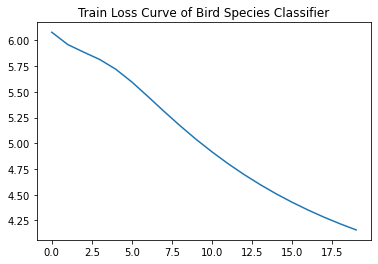

In [37]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Species Classifier')

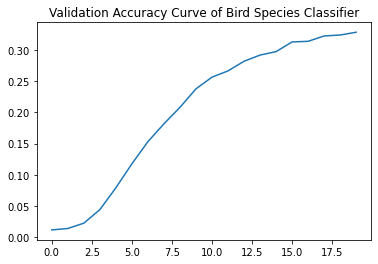

In [38]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Log-score Curve of Bird Species Classifier')

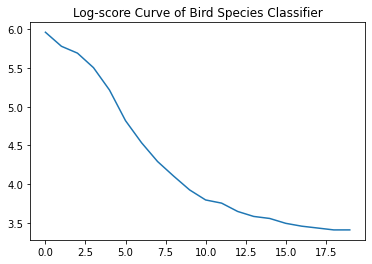

In [39]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Species Classifier')

Text(0.5, 1.0, 'F-beta score Curve of Bird Species Classifier')

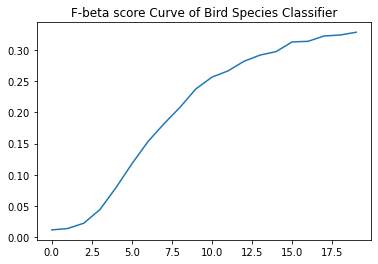

In [40]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Species Classifier')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 32.24
Log Loss score:	3.43
Fbeta-score (beta=1.0): 	0.32
